<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Семинар: рекомендательные системы - 2</center></h2>

In [1]:
# Картинки
from IPython.display import clear_output

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Фиксируем размер графиков
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.sans-serif": ["Benton Sans"]})

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Рекомендация фильмов

В этом семинаре рассмотрим рекомендательную систему фильмов на основе нейронных сетей. Будем работать с данными, которые сожержат 1,000,209 анонимных рейтингов для примерно 3,900 фильмов от 6,040 пользователей MovieLens, которые присоединись в 2000.

<center><img src="https://i.imgflip.com/1pvf4b.jpg" width="400"></center>

**Source:** https://grouplens.org/datasets/movielens/1m/

In [2]:
# скачаем данные
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/movies.dat
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/users.dat
!wget https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/ratings.dat

--2021-04-25 07:42:47--  https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/movies.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 171308 (167K) [text/plain]
Saving to: ‘movies.dat’

movies.dat          100%[===================>] 167.29K  --.-KB/s    in 0.02s   

2021-04-25 07:42:48 (9.76 MB/s) - ‘movies.dat’ saved [171308/171308]

--2021-04-25 07:42:48--  https://raw.githubusercontent.com/gaoxx643/MovieLens-1M-Dataset/master/users.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 134368 (131K) [text/plai

### MOVIES FILE DESCRIPTION

Movie information is in the file "movies.dat" and is in the following
format:

MovieID::Title::Genres

- Titles are identical to titles provided by the IMDB (including
year of release)
- Genres are pipe-separated and are selected from the following genres:

    * Action
    * Adventure
    * Animation
    * Children's
    * Comedy
    * Crime
    * Documentary
    * Drama
    * Fantasy
    * Film-Noir
    * Horror
    * Musical
    * Mystery
    * Romance
    * Sci-Fi
    * Thriller
    * War
    * Western

- Some MovieIDs do not correspond to a movie due to accidental duplicate
entries and/or test entries
- Movies are mostly entered by hand, so errors and inconsistencies may exist

In [3]:
movies = pd.read_csv("movies.dat", sep="::", engine='python', header=None)
movies.columns = ["MovieID", "Title", "Genres"]
movies.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


### USERS FILE DESCRIPTION

User information is in the file "users.dat" and is in the following
format:

UserID::Gender::Age::Occupation::Zip-code

All demographic information is provided voluntarily by the users and is
not checked for accuracy.  Only users who have provided some demographic
information are included in this data set.

- Gender is denoted by a "M" for male and "F" for female
- Age is chosen from the following ranges:

    *  1:  "Under 18"
    * 18:  "18-24"
    * 25:  "25-34"
    * 35:  "35-44"
    * 45:  "45-49"
    * 50:  "50-55"
    * 56:  "56+"

- Occupation is chosen from the following choices:

    *  0:  "other" or not specified
    *  1:  "academic/educator"
    *  2:  "artist"
    *  3:  "clerical/admin"
    *  4:  "college/grad student"
    *  5:  "customer service"
    *  6:  "doctor/health care"
    *  7:  "executive/managerial"
    *  8:  "farmer"
    *  9:  "homemaker"
    * 10:  "K-12 student"
    * 11:  "lawyer"
    * 12:  "programmer"
    * 13:  "retired"
    * 14:  "sales/marketing"
    * 15:  "scientist"
    * 16:  "self-employed"
    * 17:  "technician/engineer"
    * 18:  "tradesman/craftsman"
    * 19:  "unemployed"
    * 20:  "writer"

In [4]:
users = pd.read_csv("users.dat", sep="::", engine='python', header=None)
users.columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users.head(10)

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


### RATINGS FILE DESCRIPTION

All ratings are contained in the file "ratings.dat" and are in the
following format:

UserID::MovieID::Rating::Timestamp

- UserIDs range between 1 and 6040 
- MovieIDs range between 1 and 3952
- Ratings are made on a 5-star scale (whole-star ratings only)
- Timestamp is represented in seconds since the epoch as returned by time(2)
- Each user has at least 20 ratings

In [5]:
ratings = pd.read_csv("ratings.dat", sep="::", engine='python', header=None)
ratings.columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings.head(10)

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


# Предобработанные данные

Для построения нашей рекомендательной системы мы будем использовать уже подготовленные данные. 

In [6]:
# загружаем данные
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.negative
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating
!wget https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.train.rating

--2021-04-25 07:42:59--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.negative
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2891424 (2.8M) [text/plain]
Saving to: ‘ml-1m.test.negative’

ml-1m.test.negative 100%[===================>]   2.76M  --.-KB/s    in 0.08s   

2021-04-25 07:43:00 (36.7 MB/s) - ‘ml-1m.test.negative’ saved [2891424/2891424]

--2021-04-25 07:43:00--  https://raw.githubusercontent.com/hexiangnan/neural_collaborative_filtering/master/Data/ml-1m.test.rating
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP re

Данные предварительно предобработаны:

**train.rating:**
- Train file.
- Each Line is a training instance: userID itemID rating timestamp (if have)

In [7]:
train_data = pd.read_csv("ml-1m.train.rating", sep='\t', header=None, 
                         names=['user', 'item', 'rating', 'timestamp'], 
                         usecols=[0, 1, 2, 3], 
                         dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32})
train_data.head()

,user,item,rating,timestamp
0,0,32,4,978824330
1,0,34,4,978824330
2,0,4,5,978824291
3,0,35,4,978824291
4,0,30,4,978824291


In [8]:
user_num = train_data['user'].max() + 1
item_num = train_data['item'].max() + 1

user_num, item_num

(6040, 3706)

In [9]:
train_data = train_data[['user', 'item']].values.tolist()
train_data[:5]

[[0, 32], [0, 34], [0, 4], [0, 35], [0, 30]]

Матрица ретингов: строки — пользователи, столбцы — фильмы, на пересечении стоит рейтинг, где 0 (не смотрел фильм) или 1 (смотрел).

In [10]:
import scipy.sparse as sp

# load ratings as a dok matrix
train_mat = sp.dok_matrix((user_num, item_num), dtype=np.float32)
for x in tqdm(train_data):
    train_mat[x[0], x[1]] = 1.0
    
# train_mat[userID, itemID] = 0 or 1

In [11]:
train_mat

<6040x3706 sparse matrix of type '<class 'numpy.float32'>'
	with 994169 stored elements in Dictionary Of Keys format>

**test.rating:**
- Test file (positive instances). 
- Each Line is a testing instance: userID itemID rating timestamp (if have)

In [12]:
test_data = pd.read_csv("ml-1m.test.rating", sep='\t', header=None, 
                        names=['user', 'item', 'rating', 'timestamp'], 
                         usecols=[0, 1, 2, 3], 
                        dtype={0: np.int32, 1: np.int32, 2: np.int32, 3: np.int32})
test_data.head()

,user,item,rating,timestamp
0,0,25,5,978824351
1,1,133,3,978300174
2,2,207,4,978298504
3,3,208,4,978294282
4,4,222,2,978246585


**test.negative**
- Test file (negative instances).
- Each line corresponds to the line of test.rating, containing 99 negative samples (99 фильмов, которые пользователь еще не смотрел).  
- Each line is in the format: (userID,itemID) negativeItemID1 negativeItemID2 ...

Это подготовленный набор данных, который мы будем использовать для тестирования нашей рекомендательной системы. Для каждого пользователя он содержит 1 фильм, который он сомтрел, и 99 фильмов, которые он НЕ смотрел. Мы будем использовать их для подсчета метрик качества.

In [13]:
test_data = []
with open("ml-1m.test.negative", 'r') as fd:
    line = fd.readline()
    while line != None and line != '':
        arr = line.split('\t')
        u = eval(arr[0])[0]
        test_data.append([u, eval(arr[0])[1]])
        for i in arr[1:]:
            test_data.append([u, int(i)])
        line = fd.readline()

In [14]:
# юзер 0 смотрел только 25 фильм, а остальные фильмы (1064, 174, 2791, 3373) — нет
test_data[:5]

[[0, 25], [0, 1064], [0, 174], [0, 2791], [0, 3373]]

# Подготовка dataloaders

Реализуем специальный класс для работы с данными. 

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
import torch.utils.data as data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
class NCFData(data.Dataset):
    def __init__(self, features, num_item, train_mat=None, num_ng=0, is_training=None):
        super(NCFData, self).__init__()
        """ 
        Note that the labels are only useful when training, we thus 
        add them in the ng_sample() function.
        """
        self.features_ps = features
        self.num_item = num_item
        self.train_mat = train_mat
        self.num_ng = num_ng
        self.is_training = is_training
        self.labels = [0 for _ in range(len(features))]

    
    def ng_sample(self):
        # Добавляем фильмы, которые пользователь не смотрел.
        # Это нужно для примеров 0-го класса при обучении.
        
        assert self.is_training, 'no need to sampling when testing'

        self.features_ng = []
        for x in self.features_ps:
            u = x[0]
            for t in range(self.num_ng):
                j = np.random.randint(self.num_item)
                while (u, j) in self.train_mat:
                    j = np.random.randint(self.num_item)
                self.features_ng.append([u, j])

        # Тру метрки классов
        labels_ps = [1 for _ in range(len(self.features_ps))]
        labels_ng = [0 for _ in range(len(self.features_ng))]

        self.features_fill = self.features_ps + self.features_ng
        self.labels_fill = labels_ps + labels_ng

    
    def __len__(self):
        return (self.num_ng + 1) * len(self.labels)

    
    def __getitem__(self, idx):
        features = self.features_fill if self.is_training else self.features_ps
        labels = self.labels_fill if self.is_training else self.labels

        user = features[idx][0]
        item = features[idx][1]
        # Нужны только для обучения. В тесте не используются.
        label = labels[idx]          
        return user, item ,label

In [19]:
train_data[:5]
# train_mat — матрица рейтингов
# num_ng — сколько негативных сэмплов добавляем
# is_training — для какой цели генерируем негативные сэмплы

[[0, 32], [0, 34], [0, 4], [0, 35], [0, 30]]

In [20]:
train_dataset = NCFData(train_data, item_num, train_mat, num_ng=1, is_training=True)
test_dataset  = NCFData(test_data,  item_num, train_mat, num_ng=0, is_training=False)

In [21]:
# Попросим класс добавить негативных примеров (фильмы, которые не смотрел пользователь)
train_dataset.ng_sample()

In [22]:
# пример использования
print("User, Item, Label")

for idx, (user, item, label) in enumerate(train_dataset):
    print(user, item, label)
    if idx > 5: break

User, Item, Label
0 32 1
0 34 1
0 4 1
0 35 1
0 30 1
0 29 1
0 33 1


In [ ]:
# создадим лоадеры для pytorch
train_loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_loader  = data.DataLoader(test_dataset,  batch_size=100, shuffle=False, num_workers=0) # one user per batch !!!

# Neural Collaborative Filtering (NCF)

### Matrix factorization algorithm

NCF — это нейронная модель матричной факторизации, которая объединяет Generalized Matrix Factorization (GMF) и Multi-Layer Perceptron (MLP), объединяя в себе сильные стороны линейности MF и нелинейности MLP для моделирования скрытых структур user-item.

Схема архитектуры NCF:

<img src="https://recodatasets.blob.core.windows.net/images/NCF.svg?sanitize=true">

На схеме видно, как используются скрытые вектора пользователей и айтемов и как затем объединяются выходы из слоя GMF (слева) и слоя MLP (справа).

**Статья:** Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu & Tat-Seng Chua, Neural Collaborative Filtering, 2017 https://arxiv.org/abs/1708.05031

### 1 Модель GMF

В ALS, матрицу оценок можно записать как:

$$\hat { r } _ { u , i } = q _ { i } ^ { T } p _ { u }$$

GMF представляет собой слой NCF как стандартный выходной слой MF. Поэтому MF может быть легко обобщена и расширена. Например, если мы позволим веса ребер выходно слоя обучаться без общего ограничения - это даст вариант MF, который позволяет варьировать важность скрытых измерений. А если мы будем использовать нелинейную функцию активации, это даст обобщение MF до нелинейной формы, которая может быть более выразительной чем линейная MF модель. GMF может быть записана как:

$$\hat { r } _ { u , i } = a _ { o u t } \left( h ^ { T } \left( q _ { i } \odot p _ { u } \right) \right)$$

где $\odot$ — поэлементное произведение векторов, ${a}_{out}$ и ${h}$ обозначают функцию активации и веса ребер выходного слоя соответственно. MF может рассматриваться как частный случай GMF. Интуитивно, если мы используем тождественную функцию для ${a}_{out}$ и выбираем единичный вектор в качестве ${h}$, то мы в точности повторяем модель MF.

### 2 Модель MLP

NCF использует два способа при моделировании рейтингов:

1) поэлементное произведение векторов,
2) конкатенация векторов.

Сразу после контатенации скрытых признаков пользователей и айтемов применяется стандартная модель MLP. Это дает возможность наделить модель большим уровнем гибкости и нелинейности для изучения взаимодействий между $p_{u}$ и $q_{i}$. 

Запишем модель MLP модель более строго:

Для входного слоя, используется конкатенация векторов пользователей и айтемов:

$$z _ { 1 } = \phi _ { 1 } \left( p _ { u } , q _ { i } \right) = \left[ \begin{array} { c } { p _ { u } } \\ { q _ { i } } \end{array} \right]$$

Для скрытых и выходного слоев MLP запись имеет вид:

$$
\phi _ { l } \left( z _ { l } \right) = a _ { o u t } \left( W _ { l } ^ { T } z _ { l } + b _ { l } \right) , ( l = 2,3 , \ldots , L - 1 )
$$

и:

$$
\hat { r } _ { u , i } = \sigma \left( h ^ { T } \phi \left( z _ { L - 1 } \right) \right)
$$

где ${ W }_{ l }$, ${ b }_{ l }$, и ${ a }_{ out }$ обозначают матрицу весов, вектор свободных членов и функцию активации для $l$-ого слоя, соответственно. В качестве функций активации MLP слоев, мы вольны выбирать любую: сигмоиду, гиперболический тангенс, ReLU и другие. В качестве функции активации на выходном слое используется сигмоида $\sigma(x)=\frac{1}{1+e^{-x}}$, чтобы ограничить оценки диапазоном (0,1).

### 3 Смешивание GMF и MLP

Чтобы обеспечить большую гибкость нашей смешанной модели мы позволяем GMF и MLP обучать независимые эмбединги и затем комбинируем две модели объединяя их последние скрытие слои. Мы взяли $\phi^{GMF}$ из GMF:

$$\phi _ { u , i } ^ { G M F } = p _ { u } ^ { G M F } \odot q _ { i } ^ { G M F }$$

и получили $\phi^{MLP}$ из MLP:

$$\phi _ { u , i } ^ { M L P } = a _ { o u t } \left( W _ { L } ^ { T } \left( a _ { o u t } \left( \ldots a _ { o u t } \left( W _ { 2 } ^ { T } \left[ \begin{array} { c } { p _ { u } ^ { M L P } } \\ { q _ { i } ^ { M L P } } \end{array} \right] + b _ { 2 } \right) \ldots \right) \right) + b _ { L }\right.$$

Наконец, мы смешали выходы из GMF и MLP:

$$\hat { r } _ { u , i } = \sigma \left( h ^ { T } \left[ \begin{array} { l } { \phi ^ { G M F } } \\ { \phi ^ { M L P } } \end{array} \right] \right)$$

Модель сочетает линейность MF и нелинейность DNN при моделировании скрытых user–item структур.

### 4 Целевая функция

Мы можем записать функцию правдоподобия как:

$$P \left( \mathcal { R } , \mathcal { R } ^ { - } | \mathbf { P } , \mathbf { Q } , \Theta \right) = \prod _ { ( u , i ) \in \mathcal { R } } \hat { r } _ { u , i } \prod _ { ( u , j ) \in \mathcal { R } ^{ - } } \left( 1 - \hat { r } _ { u , j } \right)$$

Где $\mathcal{R}$ обозначает множество наблюдаемых взаимодействий пользователя, а $\mathcal{ R } ^ { - }$ обозначает множество негативных наблюдений. $\mathbf{P}$ и $\mathbf{Q}$ — это скрытая матрица признаков пользователей и айтемов соответственно, $\Theta$ — параметры модели. Взяв со знаком минус логарифм от правдоподобия мы получим целевую функцию для минимизации NCF алгоритма. Что-то напоминает, не правда ли? https://en.wikipedia.org/wiki/Cross_entropy

$$L = - \sum _ { ( u , i ) \in \mathcal { R } \cup { \mathcal { R } } ^ { - } } r _ { u , i } \log \hat { r } _ { u , i } + \left( 1 - r _ { u , i } \right) \log \left( 1 - \hat { r } _ { u , i } \right)$$

In [29]:
class NCF(nn.Module):
    def __init__(self, user_num, item_num, factor_num, num_layers,
                    dropout, model, GMF_model=None, MLP_model=None):
        super(NCF, self).__init__()
        
        """
        user_num: number of users;
        item_num: number of items;
        factor_num: number of predictive factors;
        num_layers: the number of layers in MLP model;
        dropout: dropout rate between fully connected layers;
        model: 'MLP', 'GMF', 'NeuMF-end', and 'NeuMF-pre';
        GMF_model: pre-trained GMF weights;
        MLP_model: pre-trained MLP weights.
        """        
        
        self.dropout = dropout
        self.model = model
        self.GMF_model = GMF_model
        self.MLP_model = MLP_model

        self.embed_user_GMF = nn.Embedding(user_num, factor_num)
        self.embed_item_GMF = nn.Embedding(item_num, factor_num)
        
        self.embed_user_MLP = nn.Embedding(user_num, factor_num * (2 ** (num_layers - 1)))
        self.embed_item_MLP = nn.Embedding(item_num, factor_num * (2 ** (num_layers - 1)))

        MLP_modules = []
        for i in range(num_layers):
            input_size = factor_num * (2 ** (num_layers - i))
            MLP_modules.append(nn.Dropout(p=self.dropout))
            MLP_modules.append(nn.Linear(input_size, input_size//2))
            MLP_modules.append(nn.ReLU())
        self.MLP_layers = nn.Sequential(*MLP_modules)

        if self.model in ['MLP', 'GMF']:
            predict_size = factor_num 
        else:
            predict_size = factor_num * 2
        self.predict_layer = nn.Linear(predict_size, 1)

        self._init_weight_()

    
    def _init_weight_(self):
        
        """ We leave the weights initialization here. """
        
        if not self.model == 'NeuMF-pre':
            nn.init.normal_(self.embed_user_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_user_MLP.weight, std=0.01)
            nn.init.normal_(self.embed_item_GMF.weight, std=0.01)
            nn.init.normal_(self.embed_item_MLP.weight, std=0.01)

            for m in self.MLP_layers:
                if isinstance(m, nn.Linear):
                    nn.init.xavier_uniform_(m.weight)
            
            nn.init.kaiming_uniform_(self.predict_layer.weight, a=1, nonlinearity='sigmoid')

            for m in self.modules():
                if isinstance(m, nn.Linear) and m.bias is not None:
                    m.bias.data.zero_()
        else:
            # embedding layers
            self.embed_user_GMF.weight.data.copy_(self.GMF_model.embed_user_GMF.weight)
            self.embed_item_GMF.weight.data.copy_(self.GMF_model.embed_item_GMF.weight)
            self.embed_user_MLP.weight.data.copy_(self.MLP_model.embed_user_MLP.weight)
            self.embed_item_MLP.weight.data.copy_(self.MLP_model.embed_item_MLP.weight)

            # mlp layers
            for (m1, m2) in zip(self.MLP_layers, self.MLP_model.MLP_layers):
                if isinstance(m1, nn.Linear) and isinstance(m2, nn.Linear):
                    m1.weight.data.copy_(m2.weight)
                    m1.bias.data.copy_(m2.bias)

            # predict layers
            predict_weight = torch.cat([
                self.GMF_model.predict_layer.weight, 
                self.MLP_model.predict_layer.weight], dim=1)
            
            precit_bias = self.GMF_model.predict_layer.bias + self.MLP_model.predict_layer.bias

            self.predict_layer.weight.data.copy_(0.5 * predict_weight)
            self.predict_layer.bias.data.copy_(0.5 * precit_bias)

    
    def forward(self, user, item):
        if not self.model == 'MLP':
            embed_user_GMF = self.embed_user_GMF(user)
            embed_item_GMF = self.embed_item_GMF(item)
            output_GMF = embed_user_GMF * embed_item_GMF
        
        if not self.model == 'GMF':
            embed_user_MLP = self.embed_user_MLP(user)
            embed_item_MLP = self.embed_item_MLP(item)
            interaction = torch.cat((embed_user_MLP, embed_item_MLP), -1)
            output_MLP = self.MLP_layers(interaction)

        if self.model == 'GMF':
            concat = output_GMF
        elif self.model == 'MLP':
            concat = output_MLP
        else:
            concat = torch.cat((output_GMF, output_MLP), -1)

        # Выдаем число от 0 до 1, интерпретируя его как вероятность того, что юзер посмотрел — или посмотрит — фильм
        prediction = self.predict_layer(concat)
        return prediction.view(-1)

In [30]:
model = NCF(user_num, item_num, factor_num=32, num_layers=3, dropout=0.0, model='NeuMF-end')
model.to(device)

loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Обучение модели

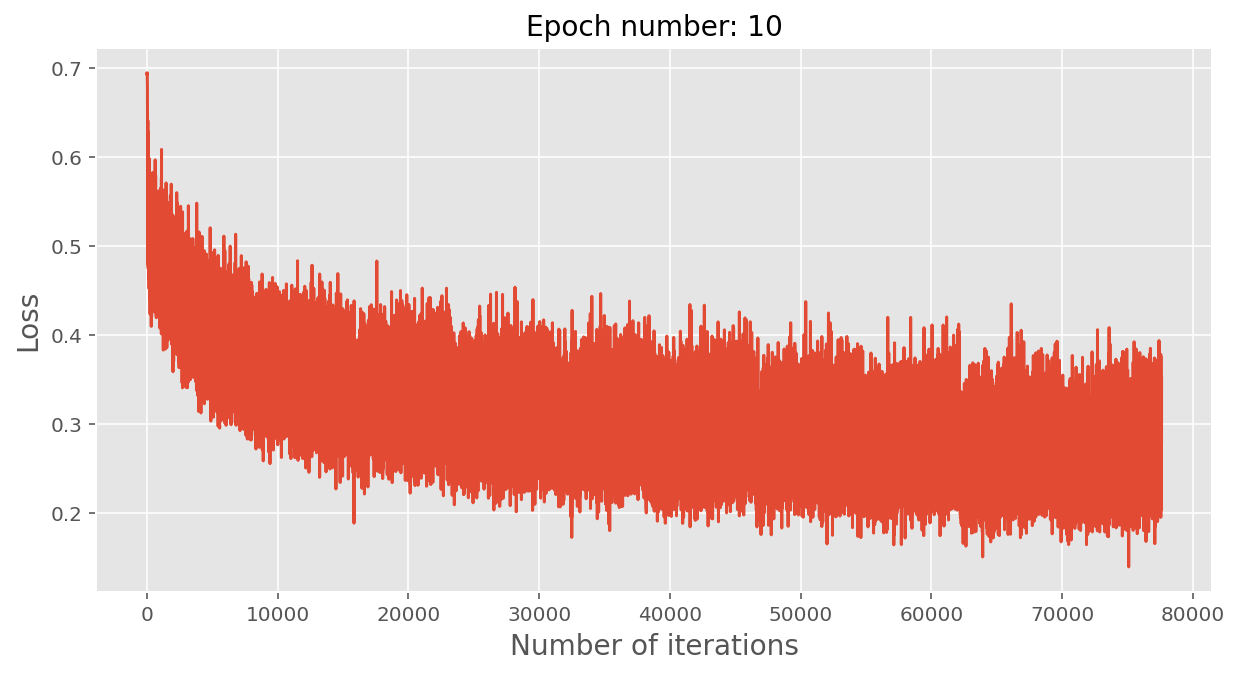

CPU times: user 11min 25s, sys: 1min 15s, total: 12min 41s
Wall time: 13min 34s


In [31]:
%%time

loss_val = []

for epoch in range(10): 
    # Train
    # Enable dropout (if have)
    model.train()
    train_loader.dataset.ng_sample()

    for user, item, label in train_loader:
        user = user.to(device)
        item = item.to(device)
        label = label.float().to(device)

        model.zero_grad()
        prediction = model(user, item)
        loss = loss_function(prediction, label)
        loss.backward()
        optimizer.step()
        
        
        # Plot learning curve
        loss_val.append(loss.cpu().detach().numpy())
        
        if len(loss_val) % 100 != 0: continue
        
        clear_output(wait=True)
        plt.figure(figsize=(10, 5))
        plt.plot(loss_val)
        plt.xlabel("Number of iterations", size=14)
        plt.ylabel("Loss", size=14)
        plt.title("Epoch number: " + str(epoch+1), size=14)
        plt.show()

# Метрики качества

**Метрики качества предсказания событий:**

$$Hitrate@k = |R_u (k) \cap L_u|$$

$$Precision@k = \frac{|R_u (k) \cap L_u|}{|R_u (k)|}$$

$$Recall@k = \frac{|R_u (k) \cap L_u|}{|L_u|}$$

где $R_u$ (k) — список k лучших рекомендаций алгоритма; $L_u$ — список фильмов, которые пользователь реально посмотрел.


**Метрики качества ранжирования:**

$$ DCG@k =  \sum_{p=1}^{k} g(r_{ui_{p}}) d(p) $$

где $p$ — позиция фильма в списке рекомендаций; $g(r) = 2^r - 1$; $d(p) = \frac{1}{\log(p+1)}$.

$$ nDCG@k =  \frac{DCG@k}{max DCG@k}$$


**Конспект**: https://github.com/hse-ds/iad-applied-ds/blob/master/2020/lectures/lecture03-recommender.pdf

### Задание 1

Напишите функцию для подсчета `Hitrate@k`.

In [32]:
def hit(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.
    
    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """
   
    if gt_item in pred_items:
        return 1
    return 0

### Задание 2

Напишите функцию для подсчета `nDCG@k`. Используйте $g(r) = 1$.

In [33]:
def ndcg(gt_item, pred_items):
    """
    gt_item : ID фильма, который пользователь реально посмотрел.
    pred_items: спискок К рекомендаций фильмов.
    
    Пример:
    gt_item = 25
    pred_items = [128, 25, 174, 273, 175, 1135, 1182, 617, 58, 1902]
    """

    if gt_item in pred_items:
        index = pred_items.index(gt_item)
        return np.reciprocal(np.log2(index+2))
    return 0


### Задание 3

Напишите функцию, которая будет считать средние значения метрик качесвта на тестовых данных. Используйте `torch.topk()` и `torch.take()`.

In [34]:
def metrics(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        user = user.to(device)
        item = item.to(device)

        predictions = model(user, item)
        _, indices = torch.topk(predictions, top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)

Посчитаем метрики качества на тесте.

In [35]:
model.eval()
HR, NDCG = metrics(model, test_loader, top_k=10)
HR, NDCG

(0.6700331125827814, 0.3941062071079209)

# Factorization Machine (FM)

Авторы статьи https://arxiv.org/abs/2005.09683 утверждают, что NCF плохо учит произведение векторов. В результате, более простые методы демонстрируют лучшее качество рекомендаций. Сравним NCF c FM.

<img src="https://s3-us-west-1.amazonaws.com/sijunhe-blog/plots/post15/fm_example.png">

Модель предполагает, что рейтинг $\hat{y}(x)$ зависит от вектора признаков следующим образом:
$$\hat{y}(x) = w_0 + \sum_{i=1}^{n}w_i x_i + \sum_{i=1}^{n} \sum_{j=i+1}^{n} <v_i, v_j> x_i x_j$$

**Конспект:** https://github.com/hse-ds/iad-applied-ds/blob/master/2020/lectures/lecture02-recommender.pdf

In [37]:
!pip install git+https://github.com/coreylynch/pyFM

  Cloning https://github.com/coreylynch/pyFM to /tmp/pip-req-build-h_4w96yi
  Running command git clone -q https://github.com/coreylynch/pyFM /tmp/pip-req-build-h_4w96yi
  Created wheel for pyfm: filename=pyfm-0.0.0-cp37-cp37m-linux_x86_64.whl size=216600 sha256=dbd3aea05d784002857559d75fe74fca0a921e5e302e75affdfd612274033416
  Stored in directory: /tmp/pip-ephem-wheel-cache-xfo8wp5k/wheels/3b/d9/ef/1b148c527d39344632833679e79b3db1798a40b0f64f917b13
Successfully built pyfm


In [38]:
from pyfm import pylibfm
from sklearn.feature_extraction import DictVectorizer

## Подготовка данных
Приведем обучающую выборку к нужному формату.

In [39]:
train_dataset_fm = []
y_train = []

for i in range(0, len(train_dataset.features_fill), 10): # весь датасет может сломать pyfm !!!
    user, item = train_dataset.features_fill[i]
    label = train_dataset.labels_fill[i]
    train_dataset_fm += [{'user': str(user), 'item': str(item)}]
    y_train += [label]

In [40]:
# пример (так надо преобразовать, чтобы все работало в pyfm)
train_dataset_fm[:5]

[{'item': '32', 'user': '0'},
 {'item': '23', 'user': '0'},
 {'item': '13', 'user': '0'},
 {'item': '45', 'user': '0'},
 {'item': '44', 'user': '0'}]

In [41]:
# пример
y_train[:5]

[1, 1, 1, 1, 1]

## Обучение FM

In [42]:
# переведем словарь в метрицу векторов x
v = DictVectorizer()
X_train = v.fit_transform(train_dataset_fm)
y_train = np.array(y_train)

In [43]:
%%time
# обучение
fm = pylibfm.FM(num_factors=32, num_iter=20, verbose=True, task="classification", 
                initial_learning_rate=0.01, learning_rate_schedule="optimal")
fm.fit(X_train, y_train)

Creating validation dataset of 0.01 of training for adaptive regularization
-- Epoch 1
Training log loss: 0.66212
-- Epoch 2
Training log loss: 0.61102
-- Epoch 3
Training log loss: 0.57773
-- Epoch 4
Training log loss: 0.55435
-- Epoch 5
Training log loss: 0.53705
-- Epoch 6
Training log loss: 0.52374
-- Epoch 7
Training log loss: 0.51319
-- Epoch 8
Training log loss: 0.50471
-- Epoch 9
Training log loss: 0.49761
-- Epoch 10
Training log loss: 0.49153
-- Epoch 11
Training log loss: 0.48630
-- Epoch 12
Training log loss: 0.48172
-- Epoch 13
Training log loss: 0.47754
-- Epoch 14
Training log loss: 0.47376
-- Epoch 15
Training log loss: 0.47022
-- Epoch 16
Training log loss: 0.46695
-- Epoch 17
Training log loss: 0.46366
-- Epoch 18
Training log loss: 0.46056
-- Epoch 19
Training log loss: 0.45748
-- Epoch 20
Training log loss: 0.45456
CPU times: user 2min 21s, sys: 282 ms, total: 2min 22s
Wall time: 2min 21s


## Измерение качества

### Задание 4

Напишите функцию, которая будет считать средние значения метрик качесвта на тестовых данных. Используйте `torch.topk()` и `torch.take()`.

In [44]:
def metricsFM(model, test_loader, top_k):
    HR, NDCG = [], []

    for user, item, label in test_loader:
        ui = [{'user': str(u), 'item': str(i)} for (u, i) in zip(user.detach().numpy(), item.detach().numpy())]
        predictions = model.predict(v.transform(ui))
        _, indices = torch.topk(torch.tensor(predictions), top_k)
        recommends = torch.take(item, indices).cpu().numpy().tolist()

        gt_item = item[0].item()
        HR.append(hit(gt_item, recommends))
        NDCG.append(ndcg(gt_item, recommends))

    return np.mean(HR), np.mean(NDCG)

In [45]:
HR, NDCG = metricsFM(fm, test_loader, top_k=10)
HR, NDCG

(0.4435430463576159, 0.24265316698289283)

# Вопросы:
- Какой из алгоритмов лучше? NCF.
- Как вы думаете почему? Потому что мы обучаем FM только на $10\%$ всей обучающей выборки, а также FM требует намного больше времени на обучение. Чтобы FM был лучше NCF необходимо намного больше эпох обучения.

# Ссылки

- Тетрадка реализовна на основе кода https://github.com/guoyang9/NCF.